In [1]:
# Run this code to make Jupyter print every
# printable statement and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# To visualize the data
import matplotlib.pyplot as plt

# Generic libraries
import seaborn as sns
import pandas as pd
import numpy as np

# Regression models
import sklearn
import scipy
from scipy.stats import t
import sklearn
from sklearn.model_selection import train_test_split #split the data into training and test
from sklearn.linear_model import LinearRegression #linear regression
from sklearn.preprocessing import PolynomialFeatures #for polynomial regression
from sklearn.metrics import r2_score, mean_squared_error

# 5-folds crossvalidation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline


# Regression

Import the datasets (for this step we need only the training set)

In [2]:
training_set = pd.read_csv("data/training_set_online_shoppers_intention.csv")

We set all the categorical types as category $\rightarrow$ non so se sia davvero utile o no, magari lo teniamo solo per la heatmap, l'ho tolto perché così facendo c'erano dei problemi con la riassegnazione della categoria other: TypeError: Cannot setitem on a Categorical with a new category (Others), set the categories first

Ho pensato che tanto poi le trasformiamo tutte in binarie, quindi fa lo stesso. Magari poi ne creiamo una copia se decidiamo di fare visual inspection sul training.

Here we group the categories with the lowest number of elements into 'others'. Since these categories doesn't have a significant number of elements we don't expect them to be significant. Giving too many importance to them may lead to overfitting problems (di questa cosa non sono sicura ed è anche scritta in un inglese che fa pena)

In [3]:
# VisitorType -> others removed
training_set = training_set[training_set['VisitorType']!='Other']

#VisitorType -> 1 = returning, 0 = new
training_set['VisitorType'] = np.where(training_set['VisitorType']=='Returning_Visitor',1,0)

# Weekend
training_set['Weekend'] = np.where(training_set['Weekend']=='False',1,0)

# Split categorical variables
months = pd.get_dummies(training_set.Month, prefix='Month')
regions = pd.get_dummies(training_set.Region, prefix='Region')

def cut_levels(x, threshold, new_value):
    x = x.copy()
    value_counts = x.value_counts()
    labels = value_counts.index[value_counts < threshold]
    x[np.in1d(x, labels)] = new_value
    return x

training_set['Browser'] = cut_levels(training_set['Browser'],100,'Others')
training_set['TrafficType'] = cut_levels(training_set['TrafficType'],100,'Others')
training_set['OperatingSystems'] = cut_levels(training_set['OperatingSystems'],100,'Others')

browser = pd.get_dummies(training_set.Browser, prefix='Browser')
traffic_type = pd.get_dummies(training_set.TrafficType, prefix='TrafficType')
operating_systems = pd.get_dummies(training_set.OperatingSystems, prefix='OperatingSystems')

Here we replace the categorical features with the dummies variables obtaining binary features

In [4]:
training_set = training_set.drop(['Unnamed: 0','Month','Region','Browser','TrafficType','OperatingSystems'], axis=1).join([months,regions,browser,traffic_type,operating_systems])
training_set.shape

(9182, 57)

In [5]:
# split the training set to separate the rows with missing values
mask = training_set['ExitRates'].isna()
training_set_missing = training_set[mask]
#training_set_missing.head()
training_set_no_missing = training_set[mask==False]
#training_set_no_missing.head()

In [6]:
X_all_features = list(np.delete(training_set.columns.values, [np.where(training_set.columns.values=='ExitRates'),np.where(training_set.columns.values=='Revenue')], axis=None))
X = training_set_no_missing[X_all_features].to_numpy()
y = training_set_no_missing['ExitRates'].to_numpy()

Now we split the training data to obtain a train and a test set to train the regression model and to compute the performance scores.

In [13]:
#splitting data
test_size = 0.1
test_seed = 50
# Split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=test_seed)
print("X_train.shape ", X_train.shape)
print("X_test.shape ", X_test.shape)

X_train.shape  (5776, 55)
X_test.shape  (642, 55)


Now we fit different polynomial regression models

## Hyperparameter selection

In [15]:
# NOTE: same code as before, we just changed the way we
# compute the validation score. Instead on a single fold,
# we use a cross validation score for each possibility!
# Look at how 'val_score' is computed!
# NOTE: We don't need to explicitely train the model, the
# function will do it for us for each train split. Also
# train scores are not reported, only the cv score!
# ======================================================

# NOTE: The API always maximises the score, so score that
# must be minimized are retured as negative values!
r2_scorer = make_scorer(r2_score, greater_is_better=True)

# or ...
# mse_scorer = 'neg_mean_squared_error'

degree = list(range(1,3))
val_scores = np.zeros(len(degree))
# Validation
for i, d in enumerate(degree):
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])
    scores = cross_val_score(model, X_train, y_train, scoring=r2_scorer, cv=5)
    val_scores[i] = np.mean(scores)

# Identifies which is the best degree
best_model_idx = np.argmax(val_scores)
best_degree = degree[best_model_idx]
# And the corresponding (best) validation score
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)
    
    
# Train again the Pipeline using the best parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])
# Note: we train on X_train_small + X_val
model = model.fit(np.concatenate([X_train]), np.concatenate([y_train]))
y_predict = model.predict(X_test)
test_score = r2_score(y_test, y_predict)

print("Test score:", test_score)

Best degree:  1 
Val score:  0.8595520704086624
Test score: 0.85272883935813


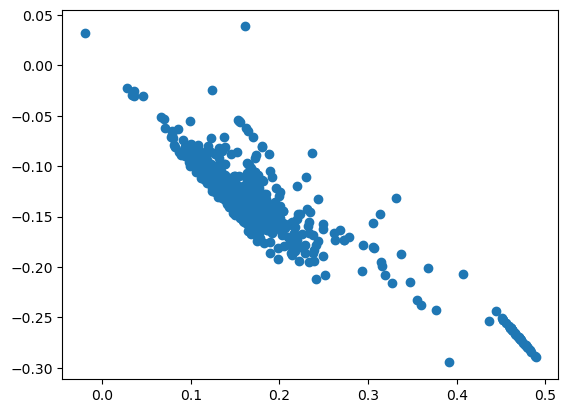

Train R2 score  0.8634539292692086
Train MSE score  0.0003125960071219233
Test R2 score  0.85272883935813
Test MSE score  0.0003539379274492473


In [30]:
residuals = y_test-y_predict
plt.scatter(y_predict,residuals)
plt.show()

print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))

In [31]:
# Convert back from numpy arrays to data frames
# just for convenience, since we can use names to
# index features
X_train_pd = pd.DataFrame(X_train, columns=X_all_features)
X_test_pd = pd.DataFrame(X_test, columns=X_all_features)

In [32]:
import itertools
def get_subsets(X_pd, dim):
    feature_names = X_pd.columns.tolist()
    # Compute all possibile combinations of 'dim' values
    subset_names = itertools.combinations(feature_names, dim) # list of list of names [[name of first candidate, ...], [...]]
    # Convert names into datasets
    data_subsets = [X_pd[list(fnames)] for fnames in subset_names]
    return data_subsets

subsets = get_subsets(X_train_pd, 3)
subsets[0].head() # training set of the first subset
subsets[1].head() # training set of the second subset

,Administrative,Administrative_Duration,Informational
0,0.0,0.0,0.0
1,1.0,229.8,0.0
2,4.0,87.5,1.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


,Administrative,Administrative_Duration,Informational_Duration
0,0.0,0.0,0.0
1,1.0,229.8,0.0
2,4.0,87.5,20.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [35]:
def rss(y_true, y_pred):
    # First we make sure the shapes are the same
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

In [36]:
def estimate_sigma(Xtrain_pd, ytrain):
    # Sigma is usually estimated using the model with all features
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def cp(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / n

def aic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / (n*sigma2)

def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

def adj_r2(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    RSS = rss(y_pred, y_true)
    TSS = tss(y_true)
    return 1 - (RSS/(n-d-1)) / (TSS/(n-1))


In [38]:
def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)
    
    return scorer

sigma = estimate_sigma(X_train_pd, y_train)
'''subset_selection(X_train_pd, y_train, X_test_pd, y_test,
                 get_evaluator(make_scorer(rss)), np.argmin, # 2.
                 get_evaluator(get_sigma_scorer(bic, sigma)), np.argmin, # 3.
                 get_evaluator(make_scorer(mean_squared_error)), np.argmin, # test
                 candidates_scorer_name="RSS",
                 subsets_scorer_name="BIC",
                 verbose=True)'''

'subset_selection(X_train_pd, y_train, X_test_pd, y_test,\n                 get_evaluator(make_scorer(rss)), np.argmin, # 2.\n                 get_evaluator(get_sigma_scorer(bic, sigma)), np.argmin, # 3.\n                 get_evaluator(make_scorer(mean_squared_error)), np.argmin, # test\n                 candidates_scorer_name="RSS",\n                 subsets_scorer_name="BIC",\n                 verbose=True)'

In [41]:
def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator  

In [39]:
from sklearn.dummy import DummyRegressor

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []  # <------ !! We keep track of selected features !!
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    #!! The loop condition is slightly changed
    #!! How many iterations we need to perform?
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Given the previous Mk model, test remaining
        # features and select the one providing the best
        # performance increment
        # ===============================================
        remaining_features = Xtrain_pd.columns.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate in (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        #!!! Update selected feature
        # ==========================
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score_test = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score_test)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how te 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()

............
Best model (M0) with 1 features: ['BounceRates']
M0 subset score (3.): 1.2137088406848757
............
Best model (M1) with 2 features: ['BounceRates', 'Administrative']
M1 subset score (3.): 1.1251127580335574
............
Best model (M2) with 3 features: ['BounceRates', 'Administrative', 'ProductRelated']
M2 subset score (3.): 1.0893882194437539
............
Best model (M3) with 4 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType']
M3 subset score (3.): 1.05412198789536
............
Best model (M4) with 5 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues']
M4 subset score (3.): 1.0367647397248339
............
Best model (M5) with 6 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2']
M5 subset score (3.): 1.02889760992174
............
Best model (M6) with 7 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'Traffi

............
Best model (M27) with 28 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'SpecialDay', 'TrafficType_4', 'Month_June', 'OperatingSystems_3', 'ProductRelated_Duration', 'TrafficType_3', 'TrafficType_13', 'TrafficType_1', 'Month_Sep', 'Region_3', 'Region_1', 'Region_9', 'Month_Dec', 'Region_4', 'Month_Jul', 'Month_Nov', 'OperatingSystems_Others', 'TrafficType_Others', 'OperatingSystems_1', 'Browser_10', 'TrafficType_20']
M27 subset score (3.): 1.0331784599118883
............
Best model (M28) with 29 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'SpecialDay', 'TrafficType_4', 'Month_June', 'OperatingSystems_3', 'ProductRelated_Duration', 'TrafficType_3', 'TrafficType_13', 'TrafficType_1', 'Month_Sep', 'Region_3', 'Region_1', 'Region_9', 'Month_Dec', 'Region_4', 'Month_Jul', 'Month_Nov', 'OperatingSystems_Others', 

............
Best model (M41) with 42 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'SpecialDay', 'TrafficType_4', 'Month_June', 'OperatingSystems_3', 'ProductRelated_Duration', 'TrafficType_3', 'TrafficType_13', 'TrafficType_1', 'Month_Sep', 'Region_3', 'Region_1', 'Region_9', 'Month_Dec', 'Region_4', 'Month_Jul', 'Month_Nov', 'OperatingSystems_Others', 'TrafficType_Others', 'OperatingSystems_1', 'Browser_10', 'TrafficType_20', 'TrafficType_8', 'Browser_Others', 'Region_7', 'Browser_5', 'Region_6', 'Browser_2', 'Month_Oct', 'Month_Feb', 'Region_2', 'TrafficType_10', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'TrafficType_5']
M41 subset score (3.): 1.0535011117997772
............
Best model (M42) with 43 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'SpecialDay', 'TrafficType_4', 'Month_June', 

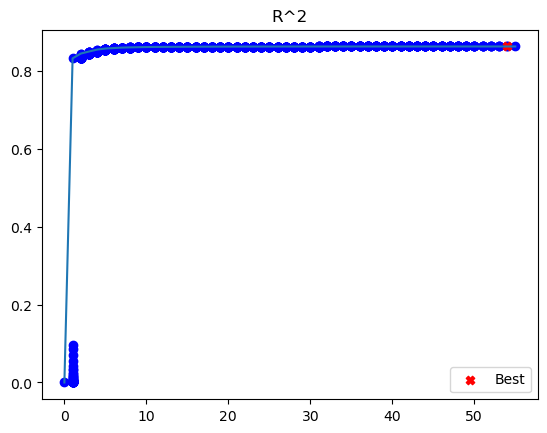

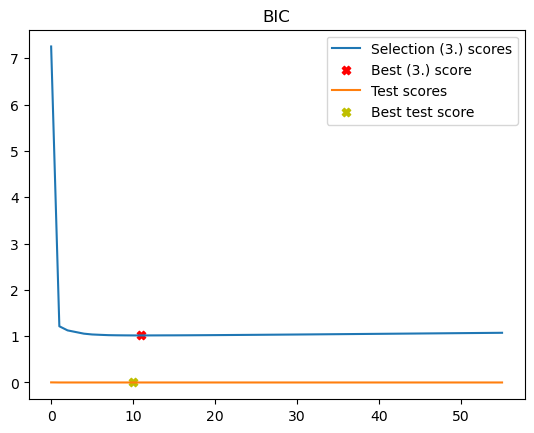

In [42]:
forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.
                  get_evaluator(get_sigma_scorer(bic, sigma)), np.argmin, # 3.
                  get_evaluator(make_scorer(mean_squared_error)), np.argmin, # test
                  candidates_scorer_name="R^2",
                  subsets_scorer_name="BIC",
                  verbose=True)

In [47]:
X_features_best = ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'SpecialDay', 'TrafficType_4', 'Month_June', 'OperatingSystems_3']

X = training_set_no_missing[X_features_best].to_numpy()
y = training_set_no_missing['ExitRates'].to_numpy()

#splitting data
test_size = 0.1
test_seed = 50
# Split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=test_seed)
print("X_train.shape ", X_train.shape)
print("X_test.shape ", X_test.shape)


degree = list(range(1,3))
val_scores = np.zeros(len(degree))
# Validation
for i, d in enumerate(degree):
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])
    scores = cross_val_score(model, X_train, y_train, scoring=r2_scorer, cv=5)
    val_scores[i] = np.mean(scores)

# Identifies which is the best degree
best_model_idx = np.argmax(val_scores)
best_degree = degree[best_model_idx]
# And the corresponding (best) validation score
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)
    
    
# Train again the Pipeline using the best parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])
# Note: we train on X_train_small + X_val
model = model.fit(np.concatenate([X_train]), np.concatenate([y_train]))
y_predict = model.predict(X_test)
test_score = r2_score(y_test, y_predict)

print("Test score:", test_score)

X_train.shape  (5776, 11)
X_test.shape  (642, 11)
Best degree:  2 
Val score:  0.8711778368283956
Test score: 0.8661454521860186
